In [1]:
!apt install -y ffmpeg
!pip install eyed3 pydub pyAudioAnalysis


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.1/246.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 kB 31.8 MB/s eta 0:00:00
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.14-py3-none-any.whl size=41264372 sha256=3eb13809204b281f3d8e0f383d7d0645497f79c05e4346e73714bdb970f1eaac
  Stored in directory: /root/.cache/pip/wheels/a7/54/73/fa830689c2440d2c81ff175c60e374930ad1607a8881e0f43f
Successfully built pyAudioAnalysis


In [3]:
import os
from pydub import AudioSegment

def load_and_convert_audio(directory):
    audio_data = []
    labels = []
    for label in ['cat', 'dog']:
        path = os.path.join(directory, label)
        for file in os.listdir(path):
            audio_path = os.path.join(path, file)
            audio = AudioSegment.from_wav(audio_path)
            # Convert to mono
            audio = audio.set_channels(1)
            audio_data.append(audio)
            labels.append(label)
    return audio_data, labels

directory = '/content/drive/MyDrive/CMPE-255/Assignment_6/I/train' # Update with your path
audio_data, labels = load_and_convert_audio(directory)


In [5]:
!pip install librosa


In [7]:
import librosa
import numpy as np

def extract_features(audio_data):
    features = []
    for audio in audio_data:
        # Convert pydub audio to numpy array
        samples = np.array(audio.get_array_of_samples())

        # Normalize the samples to floating-point values
        if audio.sample_width == 2:
            samples = samples.astype(np.float32) / 2**15
        elif audio.sample_width == 4:
            samples = samples.astype(np.float32) / 2**31
        else:
            raise ValueError('Unsupported sample width: {} bytes'.format(audio.sample_width))

        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=samples, sr=audio.frame_rate)
        features.append(mfcc.mean(axis=1))

    return features

features = extract_features(audio_data)


In [8]:
# Assuming 'features' is a list of feature arrays from the previous step
X = np.array(features)


In [10]:
import tensorflow as tf
import numpy as np

def kmeans_clustering(X, num_clusters):
    # Define the KMeans model
    kmeans = tf.compat.v1.estimator.experimental.KMeans(
        num_clusters=num_clusters,
        use_mini_batch=False,  # Disable mini-batch for small datasets
        model_dir=None,  # Use a temporary directory
        config=tf.compat.v1.estimator.RunConfig().replace(session_config=tf.compat.v1.ConfigProto(device_count={'GPU': 0}))
    )

    # Define input function
    def input_fn():
        return tf.compat.v1.train.limit_epochs(
            tf.convert_to_tensor(X, dtype=tf.float32), num_epochs=1)

    # Train the model
    kmeans.train(input_fn=input_fn)

    # Predict cluster indices
    cluster_indices = list(kmeans.predict(input_fn=input_fn))

    return cluster_indices

num_clusters = 2  # for cats and dogs
cluster_indices = kmeans_clustering(X, num_clusters)


Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
Prefer Dataset.range instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


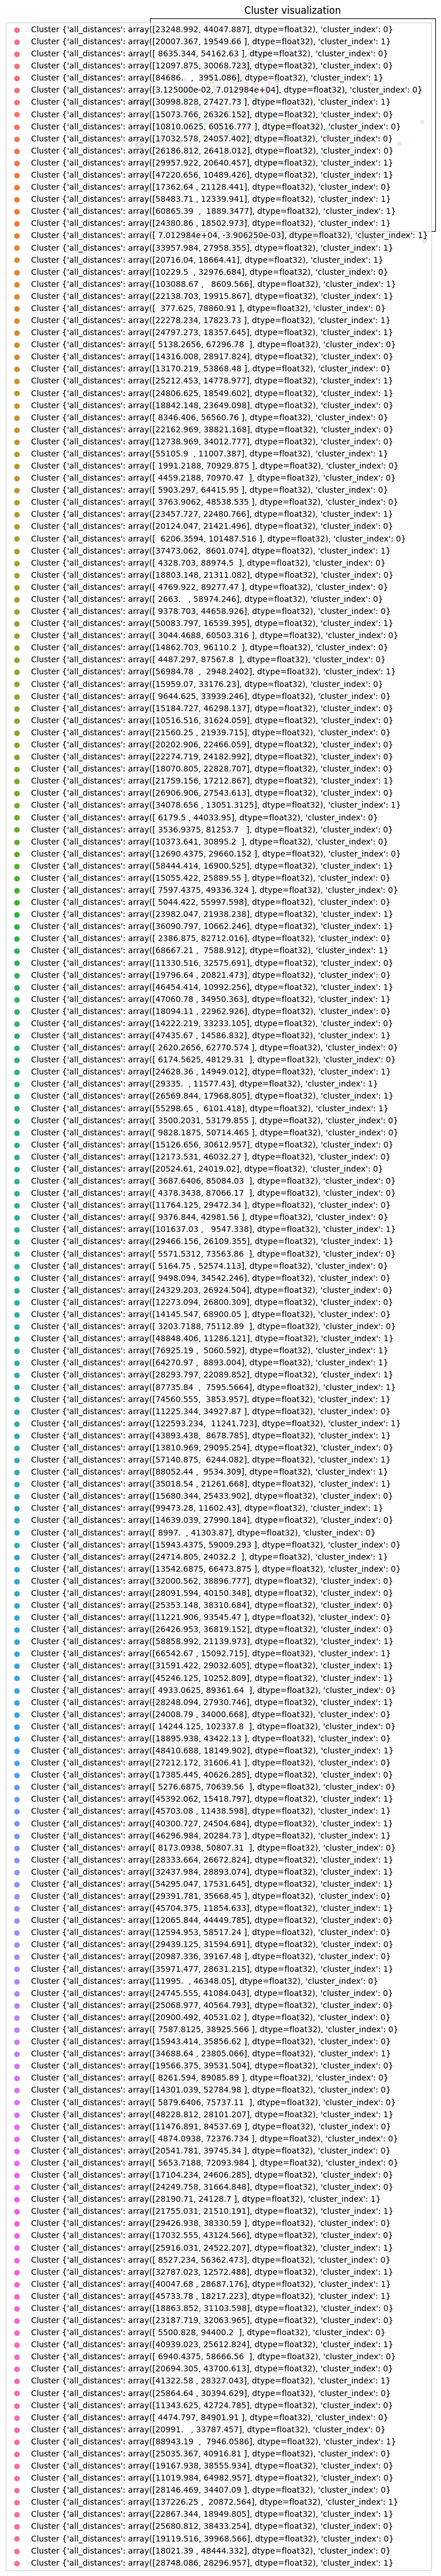

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(X, cluster_indices):
    # Convert cluster_indices to a categorical variable
    cluster_indices = [f'Cluster {cluster}' for cluster in cluster_indices]

    # Split X into separate arrays for x and y coordinates
    x_values = X[:, 0]
    y_values = X[:, 1]

    # Create a scatterplot
    sns.scatterplot(x=x_values, y=y_values, hue=cluster_indices)
    plt.title('Cluster visualization')
    plt.show()

plot_clusters(X, cluster_indices)


In [23]:
# Assuming 'labels' is a list of strings and 'cluster_indices' is a list of integers
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Calculate ARI
ari = adjusted_rand_score(labels, cluster_indices)
print(f"Adjusted Rand Index (ARI): {ari}")

# Calculate NMI
nmi = normalized_mutual_info_score(labels, cluster_indices)
print(f"Normalized Mutual Information (NMI): {nmi}")


TypeError: ignored